# FastText
The idea is extracting syntax and morphology particular to each author.

I'm using the first part of [this article](https://stackabuse.com/python-for-nlp-working-with-facebook-fasttext-library/).

In [0]:
# we get facebook's FastText
!git clone https://github.com/facebookresearch/fastText.git
! pip install fastText/.
# ... and import it
import fasttext

fatal: destination path 'fastText' already exists and is not an empty directory.
Processing ./fastText
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2854366 sha256=b0d97fddb12cdbdd2a4b8aa05ff3a8d16100432e08287901d1d25ccd647c3956
  Stored in directory: /tmp/pip-ephem-wheel-cache-x85ozi0c/wheels/a1/9f/52/696ce6c5c46325e840c76614ee5051458c0df10306987e7443
Successfully built fasttext
  Found existing installation: fasttext 0.9.1
    Uninstalling fasttext-0.9.1:
      Successfully uninstalled fasttext-0.9.1


In [0]:
# we also use Gensim for convenience, so we get it
# !pip install --upgrade gensim
# ... and import it
from gensim.models.fasttext import FastText

In [0]:
# we now need the text. We get it from Kaggle -- feel free to use my API key :)
import os
os.environ['KAGGLE_USERNAME'] = "extremelydifficult" # username from the json file
os.environ['KAGGLE_KEY'] = "238120927f9705524c124fcbdb19b699" # key from the json file
!kaggle competitions download -c spooky-author-identification
!unzip \*.zip

test.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N

Archive:  test.zip

Archive:  sample_submission.zip

3 archives were successfully processed.


In [0]:
# we now take everything into a dataframe
import pandas as pd
# get data from dataset
train = pd.read_csv('train.csv')
train.head

<bound method NDFrame.head of             id                                               text author
0      id26305  This process, however, afforded me no means of...    EAP
1      id17569  It never once occurred to me that the fumbling...    HPL
2      id11008  In his left hand was a gold snuff box, from wh...    EAP
3      id27763  How lovely is spring As we looked from Windsor...    MWS
4      id12958  Finding nothing else, not even gold, the Super...    HPL
...        ...                                                ...    ...
19574  id17718  I could have fancied, while I looked at it, th...    EAP
19575  id08973  The lids clenched themselves together as if in...    EAP
19576  id05267  Mais il faut agir that is to say, a Frenchman ...    EAP
19577  id17513  For an item of news like this, it strikes us i...    EAP
19578  id00393  He laid a gnarled claw on my shoulder, and it ...    HPL

[19579 rows x 3 columns]>

In [0]:
# we see that there's id, text, and author columns
print("Columns: ", train.columns)
# and that the most frequent author is EAP
import numpy as np
for author in np.unique(train['author']):
  print(str(author), len(train[train['author']==author]))
# the dataset is somewhat imbalanced.

Columns:  Index(['id', 'text', 'author'], dtype='object')
EAP 7900
HPL 5635
MWS 6044


In [0]:
# we split into 3 corpora for training
eap = train[train['author']=='EAP']
hpl = train[train['author']=='HPL']
mws = train[train['author']=='MWS']

# Preprocessing

## Removing periods from honorifics and such [DONE]
These need to be done by hand

In [0]:
import re

test_text = "Dr. John H. lived in the U. S. A. with  Mrs. H. for five years. . . He had lived in N.Y. before, at No. 7 Fleet St.. He was a good man."

test_text.replace("Dr.", "Dr")
test_text.replace("Mr.", "Mr")
test_text.replace("Mrs.", "Mrs")
test_text.replace("Esq.", "Esq")
test_text.replace("Messrs.", "Messrs")

'Dr. John H. lived in the U. S. A. with  Mrs. H. for five years. . . He had lived in N.Y. before, at No. 7 Fleet St.. He was a good man.'

## Removing Acronymns and one-letter abreviations [DONE]

In [0]:
[i for i in train["text"] if " : " in i][:10]

['It was at : P.M., August , that poor Klenze went wholly mad.',
 'About noon I encountered a suitable supply house far downtown, and at approximately : p.m. arrived at my boarding place with the necessary paraphernalia and two sturdy and intelligent mechanics.']

In [0]:
#remove dots from acronyms and one-letter abreviations
acronym = re.compile(r"(?<!\w)([A-Za-z])\.")
new_test_text = acronym.sub(r"\1", test_text)

In [0]:
new_test_text

'Dr. John H lived in the U S A with  Mrs. H for five years. . . He had lived in NY before, at No. 7 Fleet St.. He was a good man.'

In [0]:
#remove spaces from separated acronyms
wierd_acronym = re.compile(r"([A-Z])\s(?=[A-Z])")
wierd_acronym.sub(r"\1", new_test_text)

'Dr. John H lived in the USA with  Mrs. H for five years. . . He had lived in NY before, at No. 7 Fleet St.. He was a good man.'

## We replace . . . with ellipses [DONE] 

In [0]:
[i for i in train["text"] if ". ." in i][:10]

["they never stopped swimmin' in an' aout o' the river from that cursed reef o' Satan an' more an' more attic winders got a boarded up, an' more an' more noises was heerd in haouses as wa'n't s'posed to hev nobody in 'em. . . .",
 "all over the reef an' swimmin' up the harbour into the Manuxet. . . .",
 "and one, who led the way, was clad in a ghoulishly humped black coat and striped trousers, and had a man's felt hat perched on the shapeless thing that answered for a head. . . .",
 "An' the smell was awful, like what it is araound Wizard Whateley's ol' haouse. . .",
 "all made o' squirmin' ropes . . .",
 "Remember we're dealing with a hideous world in which we are practically helpless. . . .",
 'Madness rides the star wind . . .',
 'Mr. Maelzel, to be sure, is not very tall, but upon drawing near the machine, his head will be found at least eighteen inches below the head of the Turk, although the latter, it will be remembered, is in a sitting position. .',
 "that face with the red eye

In [0]:
fake_ellipsis = re.compile(r'(\. ){3,}')
print(fake_ellipsis.sub("\u2026 ", test_text))

Dr. John H. lived in the U. S. A. with  Mrs. H. for five years… He had lived in N.Y. before, at No. 7 Fleet St.. He was a good man.


## Turn consecutive periods into one [DONE]

In [0]:
[i for i in train["text"] if ".." in i][:10]
[i for i in train["text"] if "I said I was distrustful of the Authenticity of Ossian" in i][:10]

['When, to agree with him, I said I was distrustful of the Authenticity of Ossian\'s ms, Mr. Johnson said: "That, Sir, does not do your Understanding particular Credit; for what all the Town is sensible of, is no great Discovery for a Grub Street Critick to make.']

In [0]:
consecutiveperiods = re.compile(r'\.{2,}')
print(consecutiveperiods.sub('.', test_text))

Dr. John H. lived in the U. S. A. with  Mrs. H. for five years. . . He had lived in N.Y. before, at No. 7 Fleet St. He was a good man.


## Final Preprocessing

In [0]:
# First idea is to do minimal preprocessing and adding punctuation as words
# The idea is that authors use punctuation distinctively.
# Maybe get rid of capitalization?

import re

from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_multiple_whitespaces


CUSTOM_FILTERS = [strip_multiple_whitespaces, strip_tags]
emdash= u"\u2014"
ellipsis = u"\u2026"
punctuation = list(set(',.:;\'()"?!-'))
punctuation.append(emdash)
punctuation.append(ellipsis)


def preprocess(text):
  """Things that we were able to find"""
  text = text.replace("Dr.", "Dr")
  text = text.replace("Mr.", "Mr")
  text = text.replace("Mrs.", "Mrs")
  text = text.replace("Esq.", "Esq")
  text = text.replace("Messrs.", "Messrs")
  acronym = re.compile(r"(?<!\w)([A-Za-z])\.")
  text = acronym.sub(r"\1", text)
  wierd_acronym = re.compile(r"([A-Z])\s(?=[A-Z])")
  text = wierd_acronym.sub(r"\1", text)
  fake_ellipsis = re.compile(r'(\. ){3,}')
  text = fake_ellipsis.sub("\u2026 ", text)
  consecutiveperiods = re.compile(r'\.{2,}')
  text = consecutiveperiods.sub('.', text)
  return text

def words_as_punctuation_preprocess(text):
    text = preprocess(text)
    text = text.replace("' ", " ' ")
    prods = set(text) & set(punctuation)
    if not prods:
        return text
    for sign in prods:
        text = text.replace(sign, ' {} '.format(sign) )
    text = " ".join(preprocess_string(text, CUSTOM_FILTERS)) #we still have the same problem
    # text = " ".join(fasttext.tokenize(text))
    # text = text.encode('utf-8').strip().decode("utf-8", "strict") #we had whitespace in EAP
    return text.lower()

 # from the documentation https://github.com/facebookresearch/fastText/tree/master/python#text-classification-model, this is expected behavior: 
 # "The newline character is used to delimit lines of text. In particular, the EOS token is appended to a line of text if a newline character is encountered."

In [0]:
all_corpus = pd.DataFrame([words_as_punctuation_preprocess(i) for i in train['text']], columns= ['text'])
[i for i in all_corpus["text"] if " mr " in i][:10]

['matters had now assumed a really serious aspect , and i resolved to call at once upon my particular friend , mr theodore sinivate ; for i knew that here at least i should get something like definite information .',
 'i suppose some astonishment was exhibited in my countenance , for mr kirwin hastened to say , " immediately upon your being taken ill , all the papers that were on your person were brought me , and i examined them that i might discover some trace by which i could send to your relations an account of your misfortune and illness .',
 'sir , through our common friend , mr p , i have received your note of this evening .',
 'long and earnestly did i continue the investigation : but the contemptible reward of my industry and perseverance proved to be only a set of false teeth , two pair of hips , an eye , and a bundle of billets doux from mr windenough to my wife .',
 'when , to agree with him , i said i was distrustful of the authenticity of ossian \' s ms , mr johnson said :

In [0]:
words_as_punctuation_preprocess("this is an example. But…I shouldn't wait!")

"this is an example . but … i shouldn ' t wait !"

In [0]:
eap_corpus = pd.DataFrame([words_as_punctuation_preprocess(i) for i in eap['text']], columns= ['text'])
hpl_corpus = pd.DataFrame([words_as_punctuation_preprocess(i) for i in hpl['text']], columns= ['text'])
mws_corpus = pd.DataFrame([words_as_punctuation_preprocess(i) for i in mws['text']], columns= ['text'])

In [0]:
# embedding_size = 60
# window_size = 40
# min_word = 5
# down_sampling = 1e-2

from gensim.models.fasttext import FastText

In [0]:
from io import StringIO
import csv
from sklearn.utils import shuffle

# EAP
eap_corpus.to_csv(r'/content/eap_corpus.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")
eap_ft_model = fasttext.train_unsupervised('eap_corpus.txt')
eap_ft_model.save_model('eap_ft_model.bin')

# HPL
hpl_corpus.to_csv(r'/content/hpl_corpus.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")
hpl_ft_model = fasttext.train_unsupervised('hpl_corpus.txt')
hpl_ft_model.save_model('hpl_ft_model.bin')
# MWS
mws_corpus.to_csv(r'/content/mws_corpus.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")
mws_ft_model = fasttext.train_unsupervised('mws_corpus.txt')
mws_ft_model.save_model('mws_ft_model.bin')

# Analysis
In all authors, we see marked difference in the use of punctuation. Clusters are clear via TSNE or PCA but the frequency of nearest neighbors is very different.

## MWS

In [0]:
from sklearn.manifold import TSNE

In [0]:
word_treshold = 1000
just_keep_major_punct = True


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

ft_mws_model = FastText.load_fasttext_format('mws_ft_model.bin')

# first we check the punctuation assertion: which tokens are the most similar to exisiting punctuation?

for i in punctuation:
  print(i + ' exists: ' +str(i in ft_mws_model.wv.vocab))
# and remove the ones that don't since we need at least one n-gram with it for comparison

punctuation_in_mws = [i for i in punctuation if i in ft_mws_model.wv.vocab]

if just_keep_major_punct:
  punctuation_in_mws.remove("'")
  try:
    punctuation_in_mws.remove('…')
  except:
    pass 
  punctuation_in_mws.remove(':')
  punctuation_in_mws.remove('?')
  punctuation_in_mws.remove('"')

semantically_similar_words = {words: [item[0] for item in ft_mws_model.wv.most_similar([words], topn=word_treshold)] for words in punctuation_in_mws}
for k,v in semantically_similar_words.items():
    print(k+":"+str(v))
all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])
frequency_of_words = [ft_mws_model.wv.vocab[i].count for i in all_similar_words]
#frequency_of_words = [i if i<100 else 100 for i in frequency_of_words ]

print(all_similar_words)
print(type(all_similar_words))
print(len(all_similar_words))

word_vectors = ft_mws_model.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
#p_comps = TSNE(n_components=2, perplexity=5).fit_transform(word_vectors)

word_names = all_similar_words


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  


; exists: True
, exists: True
. exists: True
" exists: True
! exists: False
: exists: True
? exists: True
( exists: False
- exists: False
' exists: True
) exists: False
— exists: False
… exists: False


/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:2377: RuntimeWarning: invalid value encountered in true_divide
  return (m / dist).astype(REAL)


;:['sweet', 'heart', 'till', 'again', 'gods', 'livid', 'already', 'weep', 'wave', 'younger', 'glow', 'dog', 'thanks', 'still', 'youthful', 'clear', 'soothe', 'move', 'dread', 'third', 'against', 'pillow', 'shape', 'free', 'put', 'lively', 'lives', 'youth', 'sweetest', 'far', ',', 'beggar', 'wild', 'alarm', 'lot', 'dull', 'shaken', 'sword', 'thrust', 'threat', 'faith', 'dreams', 'brave', 'shrink', 'find', 'triumph', 'lonely', 'tone', 'sir', 'june', 'last', 'veil', 'level', 'evelyn', 'cast', 'bleak', 'certain', 'glad', 'shrieks', 'drink', 'agony', 'silly', 'theories', 'whisper', 'girl', 'mien', 'words', 'poet', 'crew', 'mute', 'frankenstein', 'wildly', 'voice', 'heroism', 'where', 'scream', 'keep', 'christian', 'filthy', 'blow', 'aim', 'angrily', 'double', 'help', 'strive', 'art', 'afraid', 'escape', 'laid', 'becomes', 'kishan', 'willingly', 'feeble', 'mankind', 'marry', 'doubly', 'beyond', 'sink', 'dwelt', 'ourselves', 'however', 'certainly', 'altogether', 'shake', 'hardly', 'cruelty', 

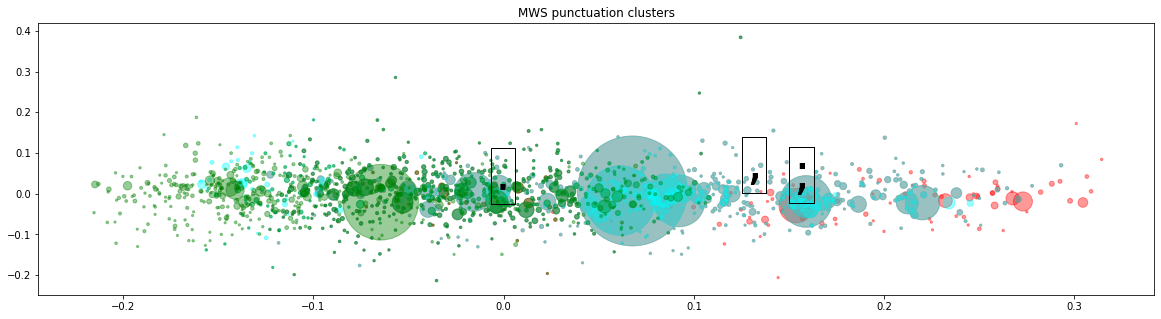

In [0]:
mycolors = [i-i%(word_treshold+1) for i in range(len(all_similar_words))]
mycolors = ['red' if i == 0 else 'cyan' if i==1001 else 'green' for i in mycolors]
plt.figure(figsize=(20, 5))
plt.title('MWS punctuation clusters')
plt.scatter(p_comps[:, 0], p_comps[:, 1], c=mycolors,  s = frequency_of_words, alpha=0.4)

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
  if word_names in punctuation_in_mws:
     plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points', size = 50, bbox=dict(facecolor='None', edgecolor='black'))
plt.show()

## EAP

In [0]:
punctuation_in_eap

NameError: ignored

In [0]:
word_treshold = 1000
just_keep_major_punct = True


eap_ft_model = FastText.load_fasttext_format('eap_ft_model.bin')

# first we check the punctuation assertion: which tokens are the most similar to exisiting punctuation?

for i in punctuation:
  print(i + ' exists: ' +str(i in eap_ft_model.wv.vocab))
# and remove the ones that don't since we need at least one n-gram with it for comparison
punctuation_in_eap = [i for i in punctuation if i in eap_ft_model.wv.vocab]

if just_keep_major_punct:
  punctuation_in_eap.remove("'")
  try:
    punctuation_in_eap.remove('…')
  except:
    pass 
  punctuation_in_eap.remove(':')
  punctuation_in_eap.remove('?')
  punctuation_in_eap.remove('"')

semantically_similar_words = {words: [item[0] for item in eap_ft_model.wv.most_similar([words], topn=word_treshold)] for words in punctuation_in_eap}
for k,v in semantically_similar_words.items():
    print(k+":"+str(v))
all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])
frequency_of_words = [eap_ft_model.wv.vocab[i].count for i in all_similar_words]
#frequency_of_words = [i if i<100 else 100 for i in frequency_of_words ]



print(all_similar_words)
print(type(all_similar_words))
print(len(all_similar_words))

word_vectors = eap_ft_model.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
#p_comps = TSNE(n_components=2, perplexity=100).fit_transform(word_vectors)

word_names = all_similar_words

# plt.figure(figsize=(18, 10))
# plt.scatter(p_comps[:, 0], p_comps[:, 1], c=[i-i%(word_treshold+1) for i in range(len(all_similar_words))], cmap='Set1', s = frequency_of_words, alpha=1)

# for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
#   if word_names in punctuation_in_eap:
#      plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points', size = 20, bbox=dict(facecolor='None', edgecolor='black'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  """


; exists: True
, exists: True
. exists: True
" exists: True
! exists: False
: exists: True
? exists: True
( exists: False
- exists: False
' exists: True
) exists: False
— exists: False
… exists: False
;:['sleep', 'freedom', 'stroke', 'chantilly', 'fearfully', 'dreadful', 'taste', 'footstep', 'glass', 'stiff', 'swept', 'vague', 'awful', 'palazzo', 'unquiet', 'dreamy', 'betook', 'unto', 'finger', 'gulf', 'beheld', 'screw', 'shriek', 'abruptly', 'slept', 'shrank', 'stupor', 'nostrils', 'burthen', 'whisper', 'seldom', 'burst', 'shrieks', 'brief', 'seize', 'raise', 'thoroughly', 'painful', 'blind', 'earnestly', 'stir', 'footsteps', 'shrill', 'shown', 'pair', 'dream', 'reward', 'wheels', 'muslin', 'risk', 'waker', 'lot', 'heels', 'shone', 'clew', 'childish', 'visit', 'hurriedly', 'quietly', 'whiskers', 'wherein', 'rash', 'razor', 'chief', 'jaws', 'pendulum', 'wept', 'built', 'pipe', 'task', 'gaze', 'sash', 'simultaneously', 'strip', 'lofoden', 'bas', 'kept', 'wealth', 'barrel', 'behavior', '

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:2377: RuntimeWarning: invalid value encountered in true_divide
  return (m / dist).astype(REAL)


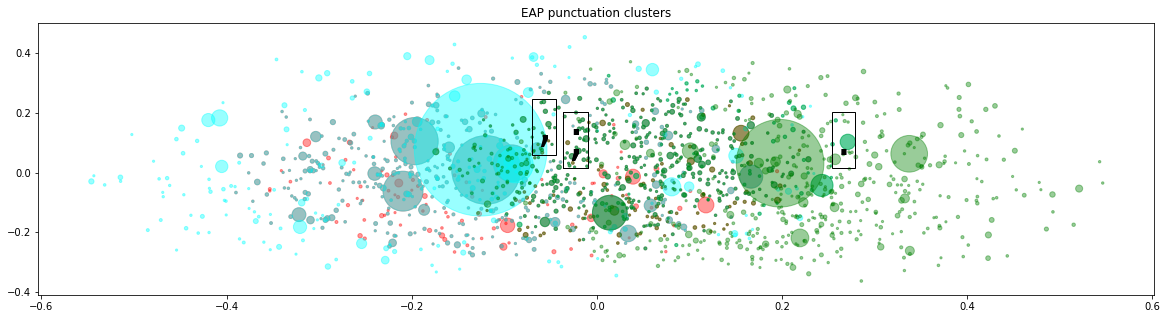

In [0]:
mycolors = [i-i%(word_treshold+1) for i in range(len(all_similar_words))]
mycolors = ['red' if i == 0 else 'cyan' if i==1001 else 'green' for i in mycolors]
plt.figure(figsize=(20, 5))
plt.title('EAP punctuation clusters')
plt.scatter(p_comps[:, 0], p_comps[:, 1], c=mycolors,  s = frequency_of_words, alpha=0.4)

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
  if word_names in punctuation_in_mws:
     plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points', size = 50, bbox=dict(facecolor='None', edgecolor='black'))
plt.show()

## HPL

In [0]:
word_treshold = 1000
just_keep_major_punct = True



hpl_ft_model = FastText.load_fasttext_format('hpl_ft_model.bin')

# first we check the punctuation assertion: which tokens are the most similar to exisiting punctuation?

for i in punctuation:
  print(i + ' exists: ' +str(i in hpl_ft_model.wv.vocab))
# and remove the ones that don't since we need at least one n-gram with it for comparison
punctuation_in_hpl = [i for i in punctuation if i in hpl_ft_model.wv.vocab]

if just_keep_major_punct:
  punctuation_in_hpl.remove('…')
  punctuation_in_hpl.remove("'")
  punctuation_in_hpl.remove(':')
  punctuation_in_hpl.remove('?')
  punctuation_in_hpl.remove('"')



semantically_similar_words = {words: [item[0] for item in hpl_ft_model.wv.most_similar([words], topn=word_treshold)] for words in punctuation_in_hpl}
for k,v in semantically_similar_words.items():
    print(k+":"+str(v))
all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])
frequency_of_words = [hpl_ft_model.wv.vocab[i].count for i in all_similar_words]
# frequency_of_words = [i if i<100 else 100 for i in frequency_of_words ]

print(all_similar_words)
print(type(all_similar_words))
print(len(all_similar_words))

word_vectors = hpl_ft_model.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
#p_comps = TSNE(n_components=2, perplexity=10).fit_transform(word_vectors)

word_names = all_similar_words

# plt.figure(figsize=(18, 10))
# plt.scatter(p_comps[:, 0], p_comps[:, 1], c=[i-i%(word_treshold+1) for i in range(len(all_similar_words))], cmap='Set1', s = frequency_of_words, alpha=1)

# for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
#   if word_names in punctuation_in_hpl:
#      plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points', size = 20, bbox=dict(facecolor='None', edgecolor='black'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  


; exists: True
, exists: True
. exists: True
" exists: True
! exists: False
: exists: True
? exists: True
( exists: False
- exists: False
' exists: True
) exists: False
— exists: False
… exists: True


/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:2377: RuntimeWarning: invalid value encountered in true_divide
  return (m / dist).astype(REAL)


;:['madly', 'responsible', 'vaguely', 'merely', 'dimly', 'sensible', 'conscious', 'appearance', 'dress', 'memorable', 'existence', 'remoteness', 'surely', 'possible', 'inaccessible', 'restlessly', 'fully', 'ice', 'entrance', 'generally', 'subtly', 'conceivable', 'barely', 'unconscious', 'fairly', 'illusion', 'equally', 'progress', 'vague', 'invisible', 'dimensions', 'easily', 'spectral', 'consciousness', 'july', 'impressions', 'suggestions', 'restless', 'ghastly', 'contents', 'peculiarly', 'constant', 'confusion', 'tense', 'event', 'revolution', 'performed', 'virtually', 'unless', 'recent', 'possession', 'prevent', 'unspeakable', 'proportions', 'connexion', 'science', 'description', 'cautious', 'mental', 'apprehension', 'element', 'inexplicable', 'dimensional', 'considerable', 'delusion', 'press', 'foundations', 'oddly', 'formerly', 'vainly', 'impossible', 'substance', 'succession', 'directly', 'scarcely', 'formless', 'suitable', 'extent', 'evidence', 'horror', 'rational', 'usually', '

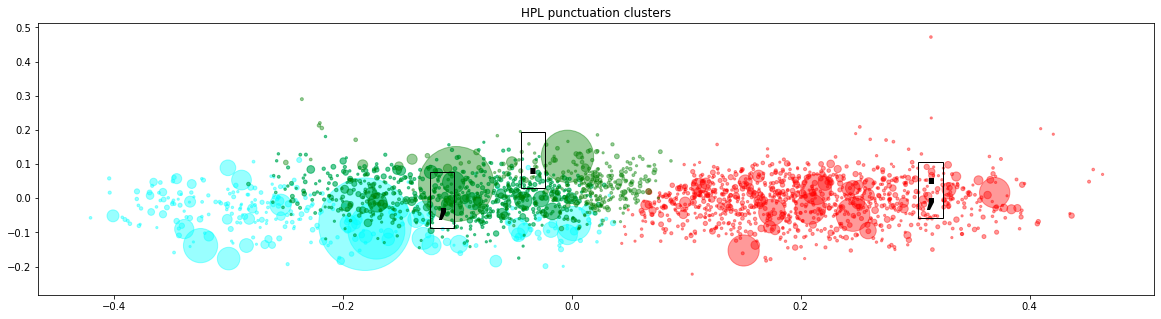

In [0]:
mycolors = [i-i%(word_treshold+1) for i in range(len(all_similar_words))]
mycolors = ['red' if i == 0 else 'cyan' if i==1001 else 'green' for i in mycolors]
plt.figure(figsize=(20, 5))
plt.title('HPL punctuation clusters')
plt.scatter(p_comps[:, 0], p_comps[:, 1], c=mycolors,  s = frequency_of_words, alpha=0.4)

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
  if word_names in punctuation_in_mws:
     plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points', size = 50, bbox=dict(facecolor='None', edgecolor='black'))
plt.show()